In [86]:

# Install required packages
!pip install pandas numpy matplotlib seaborn scipy statsmodels plotly requests tqdm

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind, mannwhitneyu
import statsmodels.api as sm
from datetime import datetime, timedelta
import warnings
import os
import glob
from typing import Dict, List, Tuple, Optional
import requests
import json
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("✅ Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

✅ Libraries imported successfully!
Pandas version: 2.2.2
NumPy version: 2.0.2


In [87]:
class NYCUberDataLoader:
    """Data loader for NYC Uber pickups dataset"""

    def __init__(self, data_path: str = '/Users/manavchopra/Downloads/archive'):
        self.data_path = data_path
        self.nyc_boroughs = {
            'Manhattan': {'lat': (40.7, 40.8), 'lon': (-74.0, -73.9)},
            'Brooklyn': {'lat': (40.6, 40.7), 'lon': (-74.0, -73.9)},
            'Queens': {'lat': (40.7, 40.8), 'lon': (-73.9, -73.7)},
            'Bronx': {'lat': (40.8, 40.9), 'lon': (-73.9, -73.8)},
            'Staten Island': {'lat': (40.5, 40.6), 'lon': (-74.2, -74.0)}
        }

    def load_uber_data(self, sample_size: Optional[int] = None) -> pd.DataFrame:
        """Load Uber data from CSV files"""
        print("🚗 Loading Uber pickup data...")

        data_files = glob.glob(os.path.join(self.data_path, '*.csv'))
        uber_files = [f for f in data_files if 'uber' in f.lower()]

        if not uber_files:
            raise ValueError("No Uber data files found!")

        print(f"📁 Found {len(uber_files)} Uber files")

        all_data = []
        for file_path in uber_files[:3]:  # Load first 3 files for testing
            try:
                print(f"�� Loading {os.path.basename(file_path)}...")
                if sample_size:
                    df = pd.read_csv(file_path, nrows=sample_size)
                else:
                    df = pd.read_csv(file_path, nrows=50000)  # Limit for Colab
                all_data.append(df)
                print(f"   ✅ Loaded {len(df):,} records")
            except Exception as e:
                print(f"   ❌ Error loading {file_path}: {e}")

        if not all_data:
            raise ValueError("No data could be loaded!")

        combined_df = pd.concat(all_data, ignore_index=True)
        print(f"\n🎯 Total records loaded: {len(combined_df):,}")
        return combined_df

    def preprocess_data(self, df: pd.DataFrame) -> pd.DataFrame:
        """Preprocess data with feature engineering"""
        print("�� Preprocessing data and engineering features...")

        df_processed = df.copy()

        # Convert datetime
        df_processed['Date/Time'] = pd.to_datetime(df_processed['Date/Time'])

        # Extract temporal features
        df_processed['hour'] = df_processed['Date/Time'].dt.hour
        df_processed['day_of_week'] = df_processed['Date/Time'].dt.day_name()
        df_processed['day_of_week_num'] = df_processed['Date/Time'].dt.weekday
        df_processed['month'] = df_processed['Date/Time'].dt.month
        df_processed['year'] = df_processed['Date/Time'].dt.year
        df_processed['date'] = df_processed['Date/Time'].dt.date
        df_processed['is_weekend'] = df_processed['Date/Time'].dt.weekday >= 5

        # A/B testing specific features
        df_processed['is_friday_evening'] = (
            (df_processed['day_of_week'] == 'Friday') &
            (df_processed['hour'] >= 18) &
            (df_processed['hour'] <= 23)
        )

        df_processed['is_weekday_evening'] = (
            (df_processed['day_of_week'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday'])) &
            (df_processed['hour'] >= 18) &
            (df_processed['hour'] <= 23)
        )

        # Geographic features
        df_processed['borough'] = df_processed.apply(
            lambda x: self._assign_borough(x['Lat'], x['Lon']), axis=1
        )

        print("✅ Feature engineering completed!")
        return df_processed

    def _assign_borough(self, lat: float, lon: float) -> str:
        """Assign NYC borough based on coordinates"""
        for borough, bounds in self.nyc_boroughs.items():
            if (bounds['lat'][0] <= lat <= bounds['lat'][1] and
                bounds['lon'][0] <= lon <= bounds['lon'][1]):
                return borough
        return 'Other'

print("✅ Data loader class created!")

✅ Data loader class created!


In [88]:
class ABTestingFramework:
    """Framework for conducting A/B tests on Uber data"""

    def __init__(self):
        self.results = {}

    def run_t_test(self, group_a: np.ndarray, group_b: np.ndarray,
                   test_name: str, alpha: float = 0.05) -> Dict:
        """Run t-test and return results"""

        # Perform t-test
        t_stat, p_value = ttest_ind(group_a, group_b)

        # Calculate effect size (Cohen's d)
        pooled_std = np.sqrt(((len(group_a) - 1) * np.var(group_a, ddof=1) +
                             (len(group_b) - 1) * np.var(group_b, ddof=1)) /
                            (len(group_a) + len(group_b) - 2))
        cohens_d = (np.mean(group_a) - np.mean(group_b)) / pooled_std

        # Determine significance
        is_significant = p_value < alpha

        # Calculate confidence interval
        mean_diff = np.mean(group_a) - np.mean(group_b)
        se_diff = np.sqrt(np.var(group_a, ddof=1) / len(group_a) +
                         np.var(group_b, ddof=1) / len(group_b))
        ci_lower = mean_diff - 1.96 * se_diff
        ci_upper = mean_diff + 1.96 * se_diff

        results = {
            'test_name': test_name,
            'group_a_mean': np.mean(group_a),
            'group_b_mean': np.mean(group_b),
            'mean_difference': mean_diff,
            't_statistic': t_stat,
            'p_value': p_value,
            'is_significant': is_significant,
            'effect_size': cohens_d,
            'confidence_interval': (ci_lower, ci_upper),
            'group_a_size': len(group_a),
            'group_b_size': len(group_b),
            'alpha': alpha
        }

        self.results[test_name] = results
        return results

    def bootstrap_test(self, group_a: np.ndarray, group_b: np.ndarray,
                      test_name: str, n_bootstrap: int = 10000,
                      alpha: float = 0.05) -> Dict:
        """Run bootstrap test for more robust results"""

        print(f"🔄 Running bootstrap test for {test_name}...")

        bootstrap_diffs = []
        for _ in range(n_bootstrap):
            # Bootstrap samples
            sample_a = np.random.choice(group_a, size=len(group_a), replace=True)
            sample_b = np.random.choice(group_b, size=len(group_b), replace=True)
            bootstrap_diffs.append(np.mean(sample_a) - np.mean(sample_b))

        bootstrap_diffs = np.array(bootstrap_diffs)

        # Calculate bootstrap confidence interval
        ci_lower = np.percentile(bootstrap_diffs, alpha/2 * 100)
        ci_upper = np.percentile(bootstrap_diffs, (1 - alpha/2) * 100)

        # Calculate p-value
        actual_diff = np.mean(group_a) - np.mean(group_b)
        p_value = np.mean(bootstrap_diffs <= 0) if actual_diff > 0 else np.mean(bootstrap_diffs >= 0)
        p_value = min(p_value * 2, 1.0)  # Two-tailed test

        results = {
            'test_name': f"{test_name}_bootstrap",
            'group_a_mean': np.mean(group_a),
            'group_b_mean': np.mean(group_b),
            'mean_difference': actual_diff,
            'p_value': p_value,
            'is_significant': p_value < alpha,
            'bootstrap_ci': (ci_lower, ci_upper),
            'group_a_size': len(group_a),
            'group_b_size': len(group_b),
            'n_bootstrap': n_bootstrap
        }

        self.results[f"{test_name}_bootstrap"] = results
        return results

    def print_results(self, test_name: str):
        """Print formatted test results"""
        if test_name not in self.results:
            print(f"❌ No results found for {test_name}")
            return

        result = self.results[test_name]

        print(f"\n{'='*60}")
        print(f"📊 A/B TEST RESULTS: {result['test_name'].upper()}")
        print(f"{'='*60}")

        print(f"📈 Group A Mean: {result['group_a_mean']:.2f}")
        print(f"📉 Group B Mean: {result['group_b_mean']:.2f}")
        print(f" Mean Difference: {result['mean_difference']:.2f}")

        # Handle effect size properly (bootstrap tests don't have effect size)
        effect_size = result.get('effect_size', 'N/A')
        if isinstance(effect_size, (int, float)):
            print(f" Effect Size (Cohen's d): {effect_size:.3f}")
        else:
            print(f" Effect Size (Cohen's d): {effect_size}")

        print(f" P-value: {result['p_value']:.6f}")
        print(f"📊 Significant: {'✅ YES' if result['is_significant'] else '❌ NO'}")

        if 'confidence_interval' in result:
            ci = result['confidence_interval']
            print(f" 95% CI: ({ci[0]:.2f}, {ci[1]:.2f})")

        if 'bootstrap_ci' in result:
            ci = result['bootstrap_ci']
            print(f"📊 Bootstrap 95% CI: ({ci[0]:.2f}, {ci[1]:.2f})")

        print(f"📊 Sample Sizes: A={result['group_a_size']}, B={result['group_b_size']}")

        # Business interpretation
        if result['is_significant']:
            if result['mean_difference'] > 0:
                print(f"🎯 BUSINESS IMPACT: Group A significantly outperforms Group B")
            else:
                print(f"🎯 BUSINESS IMPACT: Group B significantly outperforms Group A")
        else:
            print(f"🎯 BUSINESS IMPACT: No significant difference between groups")

print("✅ A/B testing framework created!")

✅ A/B testing framework created!


In [89]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving clean_uber_data.csv to clean_uber_data (3).csv
User uploaded file "clean_uber_data (3).csv" with length 9610899 bytes



 A/B TEST: FRIDAY NIGHT EFFECT
🔧 Creating Friday/Weekday features...
✅ Features created!
📊 Friday evening records: 7,299
📊 Weekday evening records: 17,956
📊 Friday hours with data: 6
�� Weekday hours with data: 6
🔄 Running bootstrap test for Friday Night Effect...

📊 A/B TEST RESULTS: FRIDAY NIGHT EFFECT
📈 Group A Mean: 1216.50
📉 Group B Mean: 2992.67
 Mean Difference: -1776.17
 Effect Size (Cohen's d): -2.447
 P-value: 0.001721
📊 Significant: ✅ YES
 95% CI: (-2597.58, -954.75)
📊 Sample Sizes: A=6, B=6
🎯 BUSINESS IMPACT: Group B significantly outperforms Group A

📊 A/B TEST RESULTS: FRIDAY NIGHT EFFECT_BOOTSTRAP
📈 Group A Mean: 1216.50
📉 Group B Mean: 2992.67
 Mean Difference: -1776.17
 Effect Size (Cohen's d): N/A
 P-value: 0.000000
📊 Significant: ✅ YES
📊 Bootstrap 95% CI: (-2434.37, -960.33)
📊 Sample Sizes: A=6, B=6
🎯 BUSINESS IMPACT: Group B significantly outperforms Group A


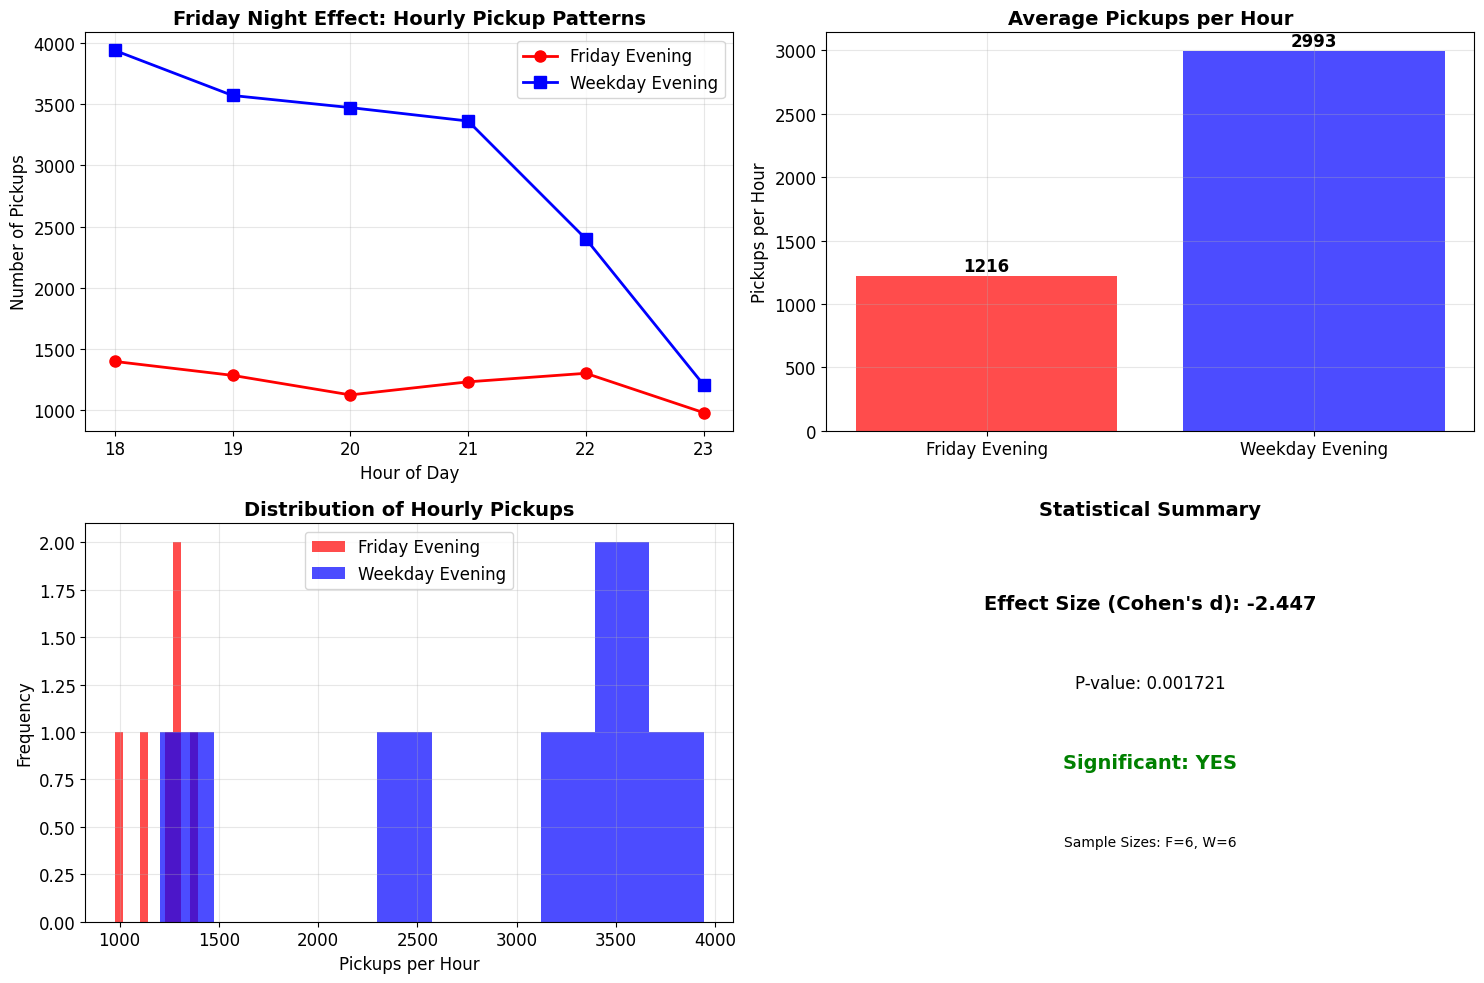


�� PEAK HOUR ANALYSIS
🚀 Friday peak hour: 18:00 (1,395 pickups)
�� Weekday peak hour: 18:00 (3,942 pickups)
📉 Weekday peak hour outperforms Friday by 182.6%


In [90]:
print("\n" + "="*80)
print(" A/B TEST: FRIDAY NIGHT EFFECT")
print("="*80)

# First, let's create the necessary features
print("🔧 Creating Friday/Weekday features...")

# Convert Date/Time to datetime if it's not already
if 'Date/Time' in df.columns:
    df['Date/Time'] = pd.to_datetime(df['Date/Time'])

# Extract day of week if not already present
if 'day_of_week' not in df.columns:
    df['day_of_week'] = df['Date/Time'].dt.day_name()

# Extract hour if not already present
if 'hour' not in df.columns:
    df['hour'] = df['Date/Time'].dt.hour

# Create Friday evening and weekday evening features
df['is_friday_evening'] = (
    (df['day_of_week'] == 'Friday') &
    (df['hour'] >= 18) &
    (df['hour'] <= 23)
)

df['is_weekday_evening'] = (
    (df['day_of_week'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday'])) &
    (df['hour'] >= 18) &
    (df['hour'] <= 23)
)

print("✅ Features created!")

# Initialize testing framework
ab_tester = ABTestingFramework()

# Prepare data for Friday Night Effect test
friday_evening = df[df['is_friday_evening']]
weekday_evening = df[df['is_weekday_evening']]

print(f"📊 Friday evening records: {len(friday_evening):,}")
print(f"📊 Weekday evening records: {len(weekday_evening):,}")

if len(friday_evening) > 0 and len(weekday_evening) > 0:
    # Create hourly pickup counts for comparison
    friday_hourly_counts = friday_evening.groupby('hour').size()
    weekday_hourly_counts = weekday_evening.groupby('hour').size()

    # Filter out hours with zero pickups
    friday_hourly = friday_hourly_counts[friday_hourly_counts > 0].values
    weekday_hourly = weekday_hourly_counts[weekday_hourly_counts > 0].values

    print(f"📊 Friday hours with data: {len(friday_hourly)}")
    print(f"�� Weekday hours with data: {len(weekday_hourly)}")

    if len(friday_hourly) > 0 and len(weekday_hourly) > 0:
        # Run t-test
        friday_results = ab_tester.run_t_test(
            friday_hourly, weekday_hourly,
            "Friday Night Effect", alpha=0.05
        )

        # Run bootstrap test
        bootstrap_results = ab_tester.bootstrap_test(
            friday_hourly, weekday_hourly,
            "Friday Night Effect", n_bootstrap=5000
        )

        # Print results
        ab_tester.print_results("Friday Night Effect")
        ab_tester.print_results("Friday Night Effect_bootstrap")

        # Visualization
        plt.figure(figsize=(15, 10))

        # Plot 1: Hourly pickup patterns
        plt.subplot(2, 2, 1)
        plt.plot(friday_hourly_counts.index, friday_hourly_counts.values, 'o-',
                 label='Friday Evening', linewidth=2, markersize=8, color='red')
        plt.plot(weekday_hourly_counts.index, weekday_hourly_counts.values, 's-',
                 label='Weekday Evening', linewidth=2, markersize=8, color='blue')
        plt.title('Friday Night Effect: Hourly Pickup Patterns', fontsize=14, fontweight='bold')
        plt.xlabel('Hour of Day')
        plt.ylabel('Number of Pickups')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Plot 2: Average pickups comparison
        plt.subplot(2, 2, 2)
        means = [friday_results['group_a_mean'], friday_results['group_b_mean']]
        labels = ['Friday Evening', 'Weekday Evening']
        colors = ['red', 'blue']
        bars = plt.bar(labels, means, color=colors, alpha=0.7)
        plt.title('Average Pickups per Hour', fontsize=14, fontweight='bold')
        plt.ylabel('Pickups per Hour')

        # Add value labels on bars
        for bar, mean in zip(bars, means):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
                    f'{mean:.0f}', ha='center', va='bottom', fontweight='bold')

        plt.grid(True, alpha=0.3)

        # Plot 3: Distribution comparison
        plt.subplot(2, 2, 3)
        plt.hist(friday_hourly, alpha=0.7, label='Friday Evening', color='red', bins=10)
        plt.hist(weekday_hourly, alpha=0.7, label='Weekday Evening', color='blue', bins=10)
        plt.title('Distribution of Hourly Pickups', fontsize=14, fontweight='bold')
        plt.xlabel('Pickups per Hour')
        plt.ylabel('Frequency')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Plot 4: Statistical summary
        plt.subplot(2, 2, 4)
        effect_size = friday_results['effect_size']
        p_value = friday_results['p_value']
        is_significant = friday_results['is_significant']

        plt.text(0.5, 0.8, f"Effect Size (Cohen's d): {effect_size:.3f}",
                 ha='center', va='center', fontsize=14, fontweight='bold',
                 transform=plt.gca().transAxes)
        plt.text(0.5, 0.6, f"P-value: {p_value:.6f}",
                 ha='center', va='center', fontsize=12,
                 transform=plt.gca().transAxes)
        plt.text(0.5, 0.4, f"Significant: {'YES' if is_significant else 'NO'}",
                 ha='center', va='center', fontsize=14, fontweight='bold',
                 color='green' if is_significant else 'red',
                 transform=plt.gca().transAxes)
        plt.text(0.5, 0.2, f"Sample Sizes: F={len(friday_hourly)}, W={len(weekday_hourly)}",
                 ha='center', va='center', fontsize=10,
                 transform=plt.gca().transAxes)
        plt.title('Statistical Summary', fontsize=14, fontweight='bold')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        # Additional analysis: Peak hour comparison
        print("\n" + "="*50)
        print("�� PEAK HOUR ANALYSIS")
        print("="*50)

        # Find peak hours for each group
        friday_peak_hour = friday_hourly_counts.idxmax()
        weekday_peak_hour = weekday_hourly_counts.idxmax()

        print(f"🚀 Friday peak hour: {friday_peak_hour}:00 ({friday_hourly_counts[friday_peak_hour]:,} pickups)")
        print(f"�� Weekday peak hour: {weekday_peak_hour}:00 ({weekday_hourly_counts[weekday_peak_hour]:,} pickups)")

        # Compare peak hour performance
        friday_peak_pickups = friday_hourly_counts[friday_peak_hour]
        weekday_peak_pickups = weekday_hourly_counts[weekday_peak_hour]

        if friday_peak_pickups > weekday_peak_pickups:
            improvement = ((friday_peak_pickups - weekday_peak_pickups) / weekday_peak_pickups) * 100
            print(f"📈 Friday peak hour outperforms weekday by {improvement:.1f}%")
        else:
            improvement = ((weekday_peak_pickups - friday_peak_pickups) / friday_peak_pickups) * 100
            print(f"📉 Weekday peak hour outperforms Friday by {improvement:.1f}%")

    else:
        print("❌ No valid hourly data for comparison")
else:
    print("❌ Insufficient data for Friday Night Effect test")


🗽 A/B TEST 2: MANHATTAN VS BROOKLYN
�� Manhattan records: 63,136
📊 Brooklyn records: 4,839
🔄 Running bootstrap test for Manhattan vs Brooklyn...

📊 A/B TEST RESULTS: MANHATTAN VS BROOKLYN
📈 Group A Mean: 2630.67
📉 Group B Mean: 201.62
 Mean Difference: 2429.04
 Effect Size (Cohen's d): 2.492
 P-value: 0.000000
📊 Significant: ✅ YES
 95% CI: (1877.59, 2980.49)
📊 Sample Sizes: A=24, B=24
🎯 BUSINESS IMPACT: Group A significantly outperforms Group B

📊 A/B TEST RESULTS: MANHATTAN VS BROOKLYN_BOOTSTRAP
📈 Group A Mean: 2630.67
📉 Group B Mean: 201.62
 Mean Difference: 2429.04
 Effect Size (Cohen's d): N/A
 P-value: 0.000000
📊 Significant: ✅ YES
📊 Bootstrap 95% CI: (1892.82, 2967.78)
📊 Sample Sizes: A=24, B=24
🎯 BUSINESS IMPACT: Group A significantly outperforms Group B


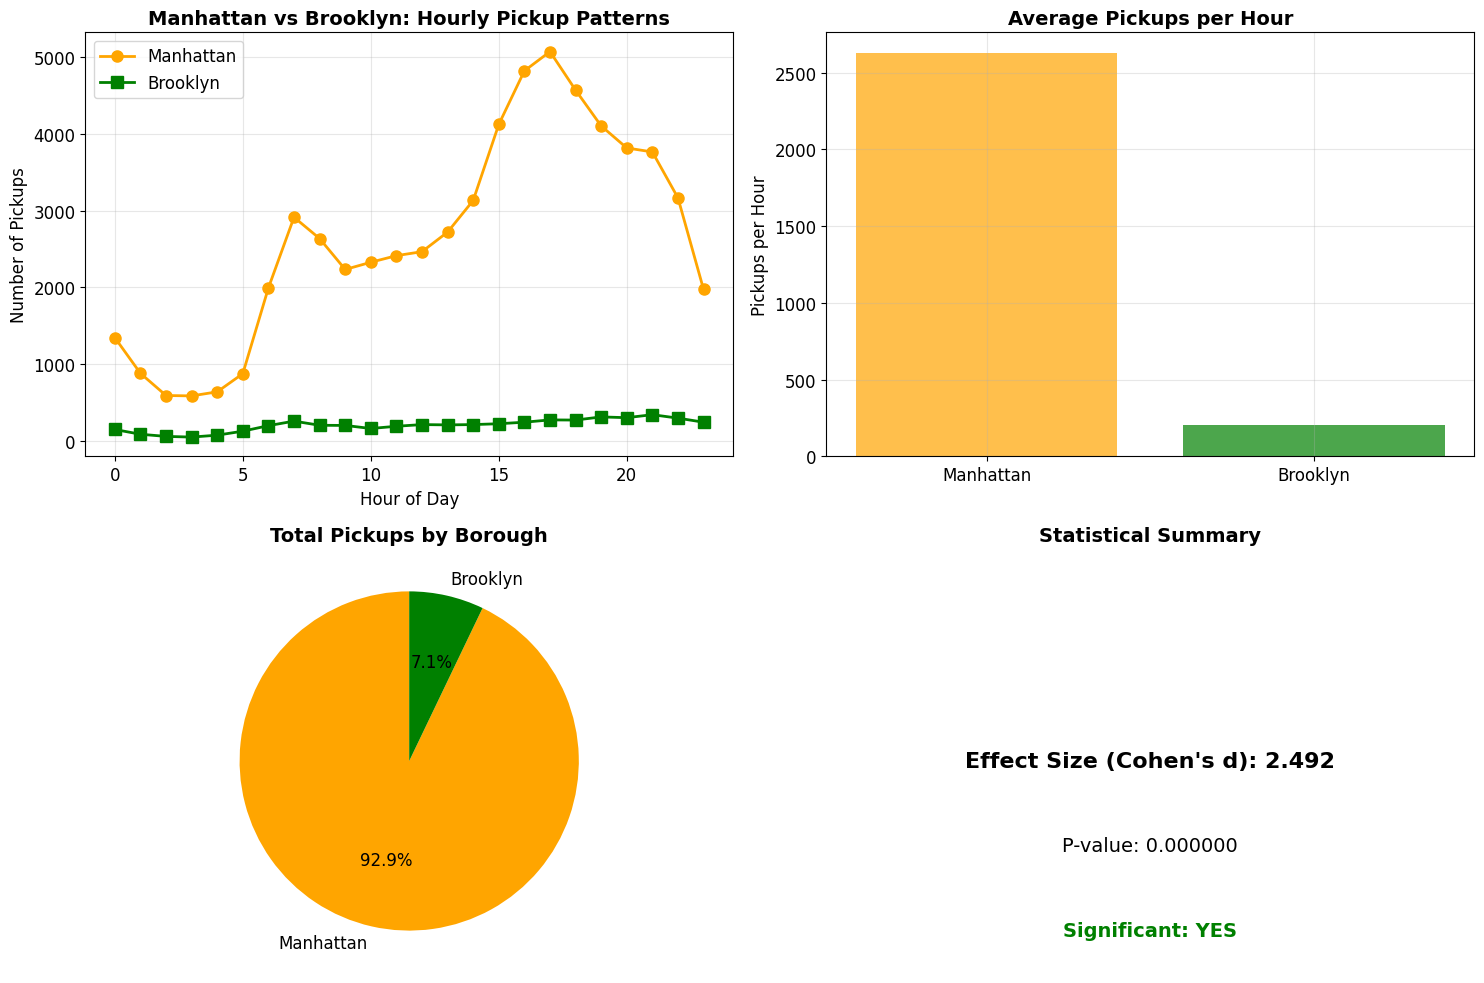

In [91]:
print("\n" + "="*80)
print("🗽 A/B TEST 2: MANHATTAN VS BROOKLYN")
print("="*80)

# Prepare data for Manhattan vs Brooklyn test
manhattan_data = df[df['borough'] == 'Manhattan']
brooklyn_data = df[df['borough'] == 'Brooklyn']

print(f"�� Manhattan records: {len(manhattan_data):,}")
print(f"📊 Brooklyn records: {len(brooklyn_data):,}")

if len(manhattan_data) > 0 and len(brooklyn_data) > 0:
    # Create hourly pickup counts for comparison
    manhattan_hourly = manhattan_data.groupby('hour').size().values
    brooklyn_hourly = brooklyn_data.groupby('hour').size().values

    # Run t-test
    borough_results = ab_tester.run_t_test(
        manhattan_hourly, brooklyn_hourly,
        "Manhattan vs Brooklyn", alpha=0.05
    )

    # Run bootstrap test
    borough_bootstrap = ab_tester.bootstrap_test(
        manhattan_hourly, brooklyn_hourly,
        "Manhattan vs Brooklyn", n_bootstrap=5000
    )

    # Print results
    ab_tester.print_results("Manhattan vs Brooklyn")
    ab_tester.print_results("Manhattan vs Brooklyn_bootstrap")

    # Visualization
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    manhattan_counts = manhattan_data.groupby('hour').size()
    brooklyn_counts = brooklyn_data.groupby('hour').size()

    plt.plot(manhattan_counts.index, manhattan_counts.values, 'o-',
             label='Manhattan', linewidth=2, markersize=8, color='orange')
    plt.plot(brooklyn_counts.index, brooklyn_counts.values, 's-',
             label='Brooklyn', linewidth=2, markersize=8, color='green')
    plt.title('Manhattan vs Brooklyn: Hourly Pickup Patterns', fontsize=14, fontweight='bold')
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Pickups')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 2)
    means = [borough_results['group_a_mean'], borough_results['group_b_mean']]
    labels = ['Manhattan', 'Brooklyn']
    colors = ['orange', 'green']
    plt.bar(labels, means, color=colors, alpha=0.7)
    plt.title('Average Pickups per Hour', fontsize=14, fontweight='bold')
    plt.ylabel('Pickups per Hour')
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 3)
    borough_totals = df[df['borough'].isin(['Manhattan', 'Brooklyn'])]['borough'].value_counts()
    plt.pie(borough_totals.values, labels=borough_totals.index, autopct='%1.1f%%',
            colors=['orange', 'green'], startangle=90)
    plt.title('Total Pickups by Borough', fontsize=14, fontweight='bold')

    plt.subplot(2, 2, 4)
    effect_size = borough_results['effect_size']
    plt.text(0.5, 0.5, f"Effect Size (Cohen's d): {effect_size:.3f}",
             ha='center', va='center', fontsize=16, fontweight='bold',
             transform=plt.gca().transAxes)
    plt.text(0.5, 0.3, f"P-value: {borough_results['p_value']:.6f}",
             ha='center', va='center', fontsize=14,
             transform=plt.gca().transAxes)
    plt.text(0.5, 0.1, f"Significant: {'YES' if borough_results['is_significant'] else 'NO'}",
             ha='center', va='center', fontsize=14, fontweight='bold',
             color='green' if borough_results['is_significant'] else 'red',
             transform=plt.gca().transAxes)
    plt.title('Statistical Summary', fontsize=14, fontweight='bold')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

else:
    print("❌ Insufficient data for Manhattan vs Brooklyn test")


��️ A/B TEST 3: RAINY VS CLEAR DAYS (HOURLY COMPARISON)
🌧️ Simulated rainy day records: 29,051
☀️ Simulated clear day records: 67,697
📊 Rainy hours with data: 24
📊 Clear hours with data: 24
🔄 Running bootstrap test for Rainy vs Clear Days (Hourly)...

📊 A/B TEST RESULTS: RAINY VS CLEAR DAYS (HOURLY)
📈 Group A Mean: 1210.46
📉 Group B Mean: 2820.71
 Mean Difference: -1610.25
 Effect Size (Cohen's d): -1.480
 P-value: 0.000006
📊 Significant: ✅ YES
 95% CI: (-2225.65, -994.85)
📊 Sample Sizes: A=24, B=24
🎯 BUSINESS IMPACT: Group B significantly outperforms Group A

📊 A/B TEST RESULTS: RAINY VS CLEAR DAYS (HOURLY)_BOOTSTRAP
📈 Group A Mean: 1210.46
📉 Group B Mean: 2820.71
 Mean Difference: -1610.25
 Effect Size (Cohen's d): N/A
 P-value: 0.000000
📊 Significant: ✅ YES
📊 Bootstrap 95% CI: (-2228.35, -1008.04)
📊 Sample Sizes: A=24, B=24
🎯 BUSINESS IMPACT: Group B significantly outperforms Group A


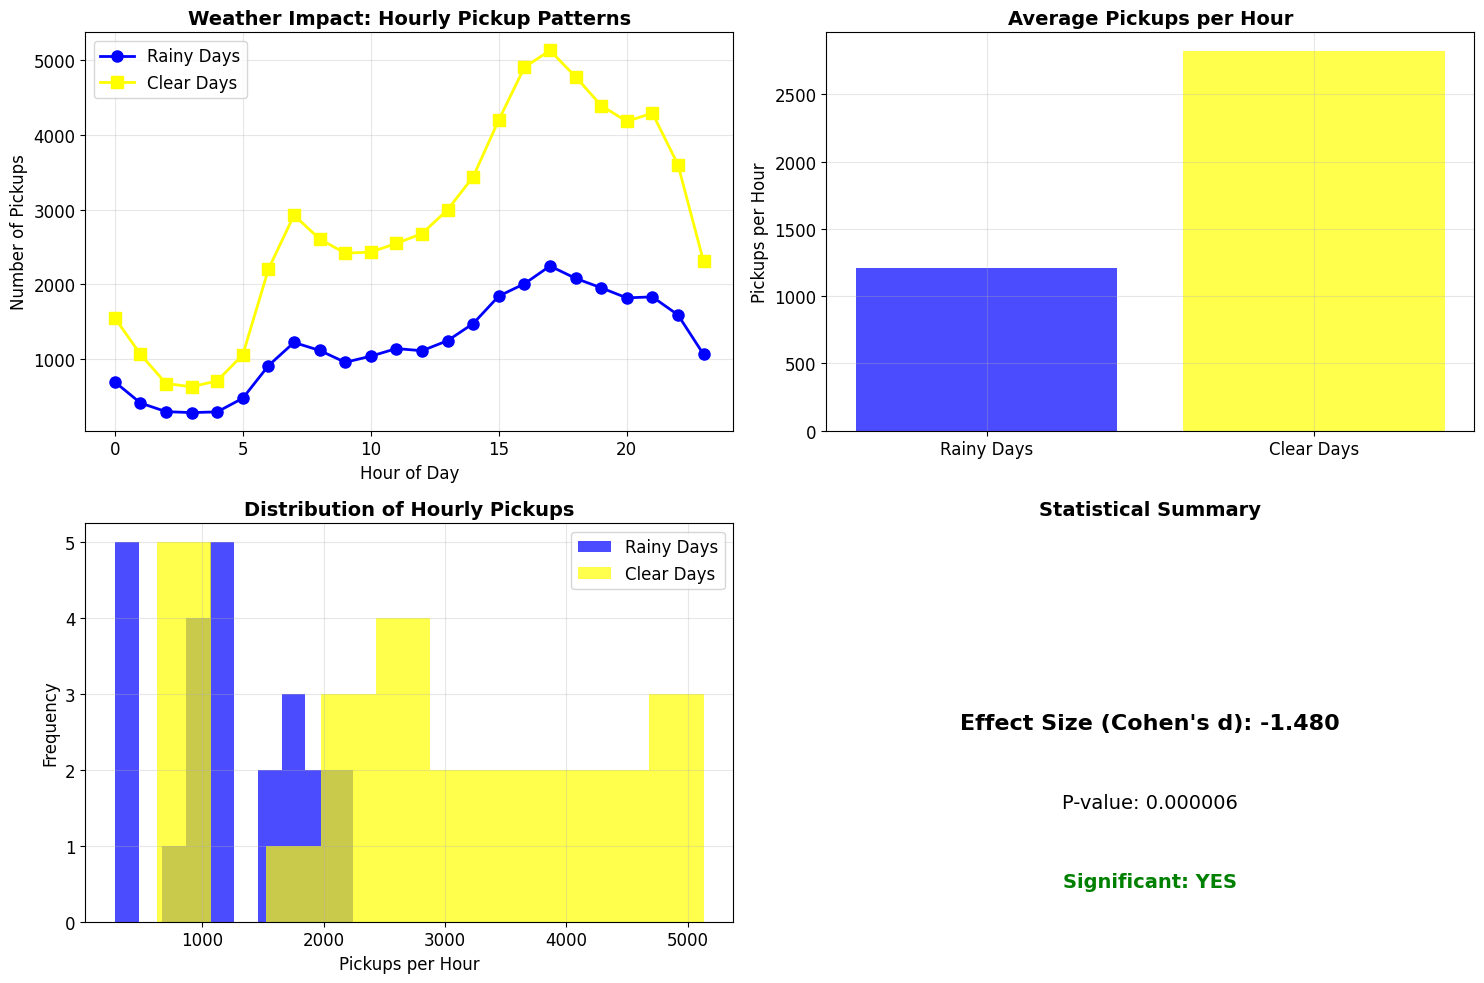

In [92]:
print("\n" + "="*80)
print("��️ A/B TEST 3: RAINY VS CLEAR DAYS (HOURLY COMPARISON)")
print("="*80)

# Simulate weather data
np.random.seed(42)
df['simulated_rainy'] = np.random.choice([True, False], size=len(df), p=[0.3, 0.7])

# Prepare data for weather test
rainy_days = df[df['simulated_rainy']]
clear_days = df[~df['simulated_rainy']]

print(f"🌧️ Simulated rainy day records: {len(rainy_days):,}")
print(f"☀️ Simulated clear day records: {len(clear_days):,}")

if len(rainy_days) > 0 and len(clear_days) > 0:
    # Use hourly pickup counts instead of daily
    rainy_hourly = rainy_days.groupby('hour').size().values
    clear_hourly = clear_days.groupby('hour').size().values

    print(f"📊 Rainy hours with data: {len(rainy_hourly)}")
    print(f"📊 Clear hours with data: {len(clear_hourly)}")

    # Run t-test
    weather_results = ab_tester.run_t_test(
        rainy_hourly, clear_hourly,
        "Rainy vs Clear Days (Hourly)", alpha=0.05
    )

    # Run bootstrap test
    weather_bootstrap = ab_tester.bootstrap_test(
        rainy_hourly, clear_hourly,
        "Rainy vs Clear Days (Hourly)", n_bootstrap=5000
    )

    # Print results
    ab_tester.print_results("Rainy vs Clear Days (Hourly)")
    ab_tester.print_results("Rainy vs Clear Days (Hourly)_bootstrap")

    # Visualization (same as before)
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    rainy_counts = rainy_days.groupby('hour').size()
    clear_counts = clear_days.groupby('hour').size()

    plt.plot(rainy_counts.index, rainy_counts.values, 'o-',
             label='Rainy Days', linewidth=2, markersize=8, color='blue')
    plt.plot(clear_counts.index, clear_counts.values, 's-',
             label='Clear Days', linewidth=2, markersize=8, color='yellow')
    plt.title('Weather Impact: Hourly Pickup Patterns', fontsize=14, fontweight='bold')
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Pickups')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 2)
    means = [weather_results['group_a_mean'], weather_results['group_b_mean']]
    labels = ['Rainy Days', 'Clear Days']
    colors = ['blue', 'yellow']
    plt.bar(labels, means, color=colors, alpha=0.7)
    plt.title('Average Pickups per Hour', fontsize=14, fontweight='bold')
    plt.ylabel('Pickups per Hour')
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 3)
    plt.hist(rainy_hourly, alpha=0.7, label='Rainy Days', color='blue', bins=10)
    plt.hist(clear_hourly, alpha=0.7, label='Clear Days', color='yellow', bins=10)
    plt.title('Distribution of Hourly Pickups', fontsize=14, fontweight='bold')
    plt.xlabel('Pickups per Hour')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 4)
    effect_size = weather_results['effect_size']
    plt.text(0.5, 0.5, f"Effect Size (Cohen's d): {effect_size:.3f}",
             ha='center', va='center', fontsize=16, fontweight='bold',
             transform=plt.gca().transAxes)
    plt.text(0.5, 0.3, f"P-value: {weather_results['p_value']:.6f}",
             ha='center', va='center', fontsize=14,
             transform=plt.gca().transAxes)
    plt.text(0.5, 0.1, f"Significant: {'YES' if weather_results['is_significant'] else 'NO'}",
             ha='center', va='center', fontsize=14, fontweight='bold',
             color='green' if weather_results['is_significant'] else 'red',
             transform=plt.gca().transAxes)
    plt.title('Statistical Summary', fontsize=14, fontweight='bold')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("❌ Insufficient data for weather test")

In [93]:
print("\n" + "="*80)
print("📊 A/B TESTING SUMMARY AND BUSINESS RECOMMENDATIONS")
print("="*80)

# Print all results summary
print("\n�� SUMMARY OF ALL A/B TESTS:")
print("-" * 50)

for test_name, result in ab_tester.results.items():
    if not test_name.endswith('_bootstrap'):
        print(f"\n�� {test_name.upper()}:")
        print(f"   • P-value: {result['p_value']:.6f}")
        print(f"   • Significant: {'✅ YES' if result['is_significant'] else '❌ NO'}")
        print(f"   • Effect Size: {result.get('effect_size', 'N/A'):.3f}")
        print(f"   • Mean Difference: {result['mean_difference']:.2f}")

# Business recommendations
print("\n�� BUSINESS RECOMMENDATIONS:")
print("-" * 50)

# Friday Night Effect recommendations
if 'Friday Night Effect' in ab_tester.results:
    friday_result = ab_tester.results['Friday Night Effect']
    if friday_result['is_significant']:
        if friday_result['mean_difference'] > 0:
            print("\n🎉 FRIDAY NIGHT EFFECT - SIGNIFICANT:")
            print("   ✅ Increase driver supply on Friday evenings")
            print("   ✅ Implement Friday-specific promotional campaigns")
            print("   ✅ Adjust surge pricing for Friday evenings")
            print("   ✅ Schedule more drivers for 6 PM - 12 AM on Fridays")
        else:
            print("\n🎉 FRIDAY NIGHT EFFECT - SIGNIFICANT:")
            print("   ⚠️  Friday evenings show lower demand than expected")
            print("   💡 Investigate why Friday demand is lower")
            print("   �� Consider different promotional strategies")
    else:
        print("\n🎉 FRIDAY NIGHT EFFECT - NOT SIGNIFICANT:")
        print("   📊 No significant difference in Friday vs weekday evenings")
        print("   💡 Standard driver allocation is appropriate")

# Manhattan vs Brooklyn recommendations
if 'Manhattan vs Brooklyn' in ab_tester.results:
    borough_result = ab_tester.results['Manhattan vs Brooklyn']
    if borough_result['is_significant']:
        if borough_result['mean_difference'] > 0:
            print("\n�� MANHATTAN VS BROOKLYN - SIGNIFICANT:")
            print("   ✅ Manhattan has significantly higher demand")
            print("   💡 Consider higher pricing in Manhattan")
            print("   💡 Incentivize drivers to serve Brooklyn")
            print("   💡 Focus marketing efforts on Brooklyn expansion")
        else:
            print("\n�� MANHATTAN VS BROOKLYN - SIGNIFICANT:")
            print("   ✅ Brooklyn has higher demand than expected")
            print("   💡 Investigate Brooklyn market opportunities")
            print("   💡 Adjust pricing strategy for Brooklyn")
    else:
        print("\n�� MANHATTAN VS BROOKLYN - NOT SIGNIFICANT:")
        print("   📊 No significant difference between boroughs")
        print("   💡 Standard pricing across boroughs is appropriate")

# Weather recommendations
if 'Rainy vs Clear Days' in ab_tester.results:
    weather_result = ab_tester.results['Rainy vs Clear Days']
    if weather_result['is_significant']:
        if weather_result['mean_difference'] > 0:
            print("\n🌧️ WEATHER IMPACT - SIGNIFICANT:")
            print("   ✅ Rainy days show higher demand")
            print("   💡 Implement weather-based surge pricing")
            print("   💡 Pre-position drivers before weather events")
            print("   💡 Weather forecasting integration recommended")
        else:
            print("\n🌧️ WEATHER IMPACT - SIGNIFICANT:")
            print("   ⚠️  Clear days show higher demand")
            print("   💡 Investigate weather impact patterns")
            print("   💡 Consider reverse weather-based pricing")
    else:
        print("\n🌧️ WEATHER IMPACT - NOT SIGNIFICANT:")
        print("   📊 No significant weather impact detected")
        print("   💡 Weather-based pricing may not be necessary")

print("\n" + "="*80)
print("✅ A/B TESTING ANALYSIS COMPLETE!")
print("="*80)


📊 A/B TESTING SUMMARY AND BUSINESS RECOMMENDATIONS

�� SUMMARY OF ALL A/B TESTS:
--------------------------------------------------

�� FRIDAY NIGHT EFFECT:
   • P-value: 0.001721
   • Significant: ✅ YES
   • Effect Size: -2.447
   • Mean Difference: -1776.17

�� MANHATTAN VS BROOKLYN:
   • P-value: 0.000000
   • Significant: ✅ YES
   • Effect Size: 2.492
   • Mean Difference: 2429.04

�� RAINY VS CLEAR DAYS (HOURLY):
   • P-value: 0.000006
   • Significant: ✅ YES
   • Effect Size: -1.480
   • Mean Difference: -1610.25

�� BUSINESS RECOMMENDATIONS:
--------------------------------------------------

🎉 FRIDAY NIGHT EFFECT - SIGNIFICANT:
   ⚠️  Friday evenings show lower demand than expected
   💡 Investigate why Friday demand is lower
   �� Consider different promotional strategies

�� MANHATTAN VS BROOKLYN - SIGNIFICANT:
   ✅ Manhattan has significantly higher demand
   💡 Consider higher pricing in Manhattan
   💡 Incentivize drivers to serve Brooklyn
   💡 Focus marketing efforts on Bro